# ФОРМИРОВАНИЕ ЭМБЕДДИНГОВ

## 1) Импорт используемых библиотек

Сначала необходимо инпортировать все библиотеки, которые будут использоваться при инициализации эмбеддингов.

Для работы с содержимым используемого Google Диска через платформу Google Colab требуется импортировать следующие библиотеки:
- `drive` - модуль, который позволяет подключить Google Диск к виртуальной машине среды выполнения и использовать его содержимое.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Далее импортируем библиотеки, используемые непостредственно в формировании эмбеддингов:
- `pandas` - библиотека для обработки и анализа структурированных данных;
- `numpy` - библиотека, которую применяют для математических вычислений: начиная с базовых функций и заканчивая линейной алгеброй;
- `re` - библиотека, предоставляющая мощные инструменты для работы с текстом.
- `gensim` - библиотека обработки естественного языка предназначения для «Тематического моделирования»
- `os` - модуль предоставляет множество функций для работы с операционной системой;
- `multiprocessing` -  пакет стандартной библиотеки языка Python, который предоставляет интерфейс для работы с процессами, очередями, пулами процессов и многими другими удобными инструментами для параллельного программирования;
- `sklearn` - библиотека, реализующая методы машинного обучения, в состав которой входят различные алгоритмы, в том числе предназначенные для задач классификации, регрессионного и кластерного анализа данных, включая метод опорных векторов, метод случайного леса, алгоритм усиления градиента, метод k-средних и DBSCAN;
- `plotly` - графическая библиотека, которая позволяется создавать интерактивные графики.;
- `wordcloud` - библиотека, с помощью которой реализуется метод визуализации данных облако слов, используемый для представления текстовых данных, в котором размер каждого слова указывает на его частоту или важность.

In [2]:
import os
import multiprocessing

import numpy as np
import pandas as pd

import re

from gensim.parsing.preprocessing import preprocess_documents, preprocess_string
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from yellowbrick.cluster import KElbowVisualizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from wordcloud import WordCloud

## 2) Подготовка исходных данных

Сначала необходимо подготовить корпус модели Doc2Vec, на котором будет происходить обучение и который будет состоять из препроцессированных книжных аннотаций. Создадим корпус из ранее препроцессированных аннотаций датасета `corpus_annotations.csv`.

In [3]:
books = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/ВКР/children/books.csv',
    index_col='book_id'
)

df_corpus_annotations = pd.read_csv(
    filepath_or_buffer='/content/drive/MyDrive/ВКР/children/children_corpus_annotations.csv',
    index_col='book_id'
)
df_corpus_annotations['annotation'] = df_corpus_annotations['annotation'].astype(str)
df_corpus_annotations['tokens'] = df_corpus_annotations['annotation'].str.findall('[a-zA-Z0-9]+')

df_corpus_annotations

,annotation,tokens
book_id,,
287141,relat vigor prose tale aenea legendari ancesto...,"[relat, vigor, prose, tale, aenea, legendari, ..."
6066812,kara astonish discov portal open bedroom close...,"[kara, astonish, discov, portal, open, bedroom..."
89378,newberi medalist cynthia rylant classic bestse...,"[newberi, medalist, cynthia, rylant, classic, ..."
1698376,hen lai egg cow give milk eleph squirt water b...,"[hen, lai, egg, cow, give, milk, eleph, squirt..."
2592648,ben draw train take sort wonder place return bed,"[ben, draw, train, take, sort, wonder, place, ..."
...,...,...
823094,rhyme text illustr comic cat present numer exa...,"[rhyme, text, illustr, comic, cat, present, nu..."
13057172,hilari move novel david walliam number bestsel...,"[hilari, move, novel, david, walliam, number, ..."
7925060,perfect remind lookout magic wonder need thing...,"[perfect, remind, lookout, magic, wonder, need..."


Токены каждой аннотации (набор слов, входящих в аннотацию) оборачиваются в объект `TaggedDocument` библиотеки Gensim при помощи функции `create_corpus()`:

In [4]:
def create_corpus(text, tag):
    '''
    Функция создания корпуса модели Doc2Vec: токенизированный тект
    оборачивается в объекты `TaggedDocument`.

    Аргументы:
    - text (`str`) - токенизированный текст объекта, который будет оборачиваться в документ;
    - tag  (`str`) - идентификатор документа (в дальнейшем дополнятется идентификатором объекта).
    '''

    output = []
    for index, row in zip(text.index, text):
        output.append(TaggedDocument(row, [tag + str(index)]))

    return output

In [5]:
corpus_annotations = create_corpus(df_corpus_annotations['tokens'], 'annotation_')
len(corpus_annotations)

108844

In [6]:
print("Пример элемента сформированного корпуса:\n")
print(f"1) Исходная аннотация книги:\n{books.iloc[0]['description']}\n")
print(f"2) Сформированный документ:\n{corpus_annotations[0]}")

Пример элемента сформированного корпуса:

1) Исходная аннотация книги:
Relates in vigorous prose the tale of Aeneas, the legendary ancestor of Romulus, who escaped from the burning city of Troy and wandered the Mediterranean for years before settling in Italy. Patterned after the Iliad and the Odyssey, the Aeneid was composed as an epic poem by Virgil, to glorify the imperial city of Rome.

2) Сформированный документ:
TaggedDocument<['relat', 'vigor', 'prose', 'tale', 'aenea', 'legendari', 'ancestor', 'romulu', 'escap', 'burn', 'citi', 'troi', 'wander', 'mediterranean', 'year', 'settl', 'itali', 'pattern', 'iliad', 'odyssei', 'aeneid', 'compos', 'epic', 'poem', 'virgil', 'glorifi', 'imperi', 'citi', 'rome'], ['annotation_287141']>


## 3) Определение и обучение модели Doc2Vec

Воспользуемся модулем Doc2Vec библиотеки Gensim, определив следующие гиперпараметры:

In [7]:
DM = 1
VECTOR_SIZE = 200
WINDOW_SIZE = 10
SEED = 83
MIN_COUNT = 2
WORKERS = 8
NEGATIVE = 7
DM_CONCAT = 1
EPOCHS = 40

print('Используемые гиперпараметры:')
print(f"1) Используемый алгоритм обучения                - PV-DM")
print(f"2) Размерность формируемых векторов              - {VECTOR_SIZE}")
print(f"3) Размер текстового окна                        - {WINDOW_SIZE}")
print(f"4) Начальное значение генератора случайных чисел - {SEED}")
print(f"5) Наименьшая частота рассматриваемых слов       - {MIN_COUNT}")
print(f"6) Количество рабочих потоков модели             - {WORKERS}")
print(f"7) Количество негативных примеров                - {NEGATIVE}")
print(f"8) Принцип формирования вектороного пространства - конкатенация контекстных векторов")
print(f"9) Количество эпох обучения                      - {EPOCHS}")

Используемые гиперпараметры:
1) Используемый алгоритм обучения                - PV-DM
2) Размерность формируемых векторов              - 200
3) Размер текстового окна                        - 10
4) Начальное значение генератора случайных чисел - 83
5) Наименьшая частота рассматриваемых слов       - 2
6) Количество рабочих потоков модели             - 8
7) Количество негативных примеров                - 7
8) Принцип формирования вектороного пространства - конкатенация контекстных векторов
9) Количество эпох обучения                      - 40


Для определения оптимальных значений гиперпараметров модели обращался к работе [«Distributed Representations of Sentences and Documents»](https://arxiv.org/abs/1405.4053).

Далее определим модель и произведём её обучение. Обученную модель сохраним в файл `model_d2v.d2v`.

In [8]:
filename_d2v_comics_graphic = '/content/drive/MyDrive/ВКР/comics_graphic/comics_graphic_model_d2v.d2v'
filename_d2v_children = '/content/drive/MyDrive/ВКР/children/children_model_d2v.d2v'
filename_d2v = filename_d2v_children

In [9]:
%%time

if os.path.isfile(filename_d2v):
    # Загрузка предобученной модели
    model_d2v = Doc2Vec.load(filename_d2v)
else:
    # Определение и обучение модели
    model_d2v = Doc2Vec(
        dm=DM, vector_size=VECTOR_SIZE, window=WINDOW_SIZE,
        seed=SEED, min_count=MIN_COUNT, workers=WORKERS,
        negative=7, dm_concat=DM_CONCAT, epochs=EPOCHS
    )
    model_d2v.build_vocab(corpus_annotations)
    model_d2v.train(
        corpus_annotations, total_examples=model_d2v.corpus_count,
        epochs=model_d2v.epochs
    )
    model_d2v.save(filename_d2v)

CPU times: user 2.78 s, sys: 2.78 s, total: 5.56 s
Wall time: 29.1 s


Приведём пример формирования эмбеддинга из текстовой аннотации:

In [10]:
books.iloc[0]['description']

'Relates in vigorous prose the tale of Aeneas, the legendary ancestor of Romulus, who escaped from the burning city of Troy and wandered the Mediterranean for years before settling in Italy. Patterned after the Iliad and the Odyssey, the Aeneid was composed as an epic poem by Virgil, to glorify the imperial city of Rome.'

In [11]:
df_corpus_annotations.iloc[0]['annotation']

'relat vigor prose tale aenea legendari ancestor romulu escap burn citi troi wander mediterranean year settl itali pattern iliad odyssei aeneid compos epic poem virgil glorifi imperi citi rome'

In [12]:
model_d2v.infer_vector(df_corpus_annotations.iloc[0]['tokens'])

array([-1.2138232e-03,  1.4347265e-03,  6.4606047e-03, -4.4667847e-03,
        1.6721046e-03,  9.2594686e-04,  5.3429743e-03, -4.7515612e-03,
        3.6731043e-03, -8.8559417e-03, -4.1548259e-04, -7.4831001e-07,
        2.4166798e-04, -2.0115145e-03,  2.6940804e-03, -3.3130676e-03,
       -1.8897116e-03,  2.2560365e-03,  4.8183189e-03,  1.7983749e-03,
        2.5301499e-04, -7.2705187e-03, -1.9684373e-03, -6.3980073e-03,
        3.7300084e-03, -2.9668950e-03, -7.3781037e-03, -2.4838140e-04,
        1.4105535e-03,  6.4324667e-03,  2.2636091e-03,  1.6983068e-03,
       -3.3135959e-03,  4.5562484e-03, -9.4188740e-03,  6.0427431e-03,
       -9.9042244e-04, -1.8084397e-03,  1.4695216e-03,  1.7563107e-03,
       -1.3343365e-03,  1.7642548e-03, -1.0154282e-03,  5.9658760e-04,
       -2.8061899e-03,  1.2124259e-02,  4.4592144e-03,  4.2492908e-04,
        1.2715998e-03, -1.5472770e-03, -5.4926891e-03,  3.3403945e-04,
       -1.6410572e-03, -8.8728924e-04, -9.5690787e-04,  3.1624709e-03,
      

## 4) Анализ работы модели Doc2Vec

Далее произведём некоторый анализ эмбеддингов, получаемых моделью Doc2Vec. Сперва произведём выгрузку эмбеддингов, полученных при обучении на корпусе книжных аннотаций, из модели в массив:

In [13]:
embeddings = np.zeros((len(df_corpus_annotations['tokens'][:250_000]), VECTOR_SIZE))
for i in range(len(df_corpus_annotations['tokens'][:250_000])):
    embeddings[i,:] = model_d2v.dv[i].reshape((1, VECTOR_SIZE))

In [14]:
print("Пример эмбеддинга, полученного при помощи модели Doc2Vec:\n")
print(f"1) Исходный текст:\n{books.iloc[0]['description']}\n")
print(f"2) Полученный вектор:\n{embeddings[0]}")

Пример эмбеддинга, полученного при помощи модели Doc2Vec:

1) Исходный текст:
Relates in vigorous prose the tale of Aeneas, the legendary ancestor of Romulus, who escaped from the burning city of Troy and wandered the Mediterranean for years before settling in Italy. Patterned after the Iliad and the Odyssey, the Aeneid was composed as an epic poem by Virgil, to glorify the imperial city of Rome.

2) Полученный вектор:
[-8.29084963e-03 -1.76829763e-03  4.83798375e-03  9.47105791e-03
 -6.07674429e-03 -3.08325374e-03  1.20961736e-03 -6.06394792e-03
  1.12760952e-02  7.09235296e-03  7.12088170e-03 -3.76315508e-03
  7.93726742e-03  1.17525281e-02 -5.50322467e-03 -5.58801647e-03
  3.04289279e-05 -6.90393941e-03  1.96768017e-03  7.72711821e-04
  2.39320658e-03  3.88640558e-07  1.58490390e-02 -1.00999209e-03
  5.07306121e-03 -4.96758753e-03  2.51308456e-03  6.79001026e-03
  3.63722001e-03 -2.51871464e-03  9.91921290e-04  1.39052151e-02
  7.81932613e-04  1.62359315e-03 -1.54879235e-03  5.88215

Чтобы определить наличие семантического смысла в рассчитанных эмбеддингах, произведём их кластеризацию. Таким образом появляется возможность выделить некоторые смысловые группы, которые будут выражаться в принадлежности тому или иному кластеру. Для решения задачи кластеризации прибегнем к алгоритму K-Means библиотеки `Scikit-learn`.

Также воспользуемся методом локтя, который помогает по рассматриваемым данным выбрать оптимальное количество кластеров, снабжая модель K-Means диапазоном значений k (количество кластеров).

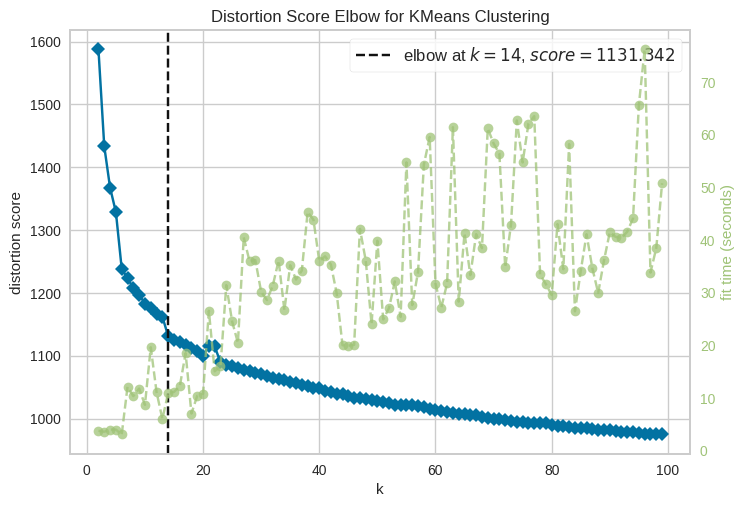

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model_kmeans = KMeans(init='k-means++', n_init=1, max_iter=300, random_state=42)
elbow_visualizer = KElbowVisualizer(model_kmeans, k=(2,100))
elbow_visualizer.fit(embeddings)
elbow_visualizer.show()

Опираясь на результаты алгоритма метода локтя, можно сказать, что оптимальное количество кластеров равно 14. Кластеризуем эмбеддинги аннотаций с полученным значением кластеров при помощи алгоритма K-Means и перенесём полученные метки кластеров на датасет с корпусом книжных аннотаций:

In [ ]:
model_kmeans = KMeans(n_clusters=14, init='k-means++', n_init=10, max_iter=300, random_state=123)
model_kmeans.fit(embeddings)

KMeans(n_clusters=14, n_init=10, random_state=123)

In [ ]:
df_corpus_annotations['cluster_label'] = model_kmeans.labels_
df_corpus_annotations = df_corpus_annotations.drop(columns=['tokens'])
df_corpus_annotations.to_csv('/content/drive/MyDrive/ВКР/children/children_corpus_annotations_clustered.csv')

df_corpus_annotations.head()

,annotation,cluster_label
book_id,,
287141,relat vigor prose tale aenea legendari ancesto...,8
6066812,kara astonish discov portal open bedroom close...,8
89378,newberi medalist cynthia rylant classic bestse...,2
1698376,hen lai egg cow give milk eleph squirt water b...,8
2592648,ben draw train take sort wonder place return bed,6


Визуализируем результаты работы в виде гистограммы распределения аннотаций по кластерам:

In [ ]:
fig = px.histogram(df_corpus_annotations, x='cluster_label')
fig.update_layout(
    title="Распределение аннотаций по кластерам",
    xaxis_title="Номер кластера",
    yaxis_title="Количество аннотаций"
)
fig.show()

Также представим облака слов аннотаций для каждого кластера. Для этого определим функцию `cluster_wordclouds()`, в которой будет производиться расчёт облаков слов, и представим результаты её работы:

In [ ]:
def cluster_wordclouds(cluster_amount):
    '''
    Функция расчёта облаков слов аннотаций для каждого кластера данных.

    Аргументы:
    - cluster_amount  (`int`) - количество рассматриваемых кластеров.
    '''

    fig = make_subplots(
        rows=int(cluster_amount/3 + 1), cols=3,
        subplot_titles=(['Кластер №{}'.format(i) for i in range(cluster_amount)])
    )

    for cluster_num in range(cluster_amount):
        row_index = int(cluster_num / 3 + 1)
        col_index = int(cluster_num % 3 + 1)
        text = ' '.join(df_corpus_annotations[df_corpus_annotations['cluster_label'] == cluster_num]['annotation'].values)
        wordcloud = WordCloud(
            width=500, height=500, min_font_size=10, background_color="white"
        ).generate(text)
        fig.add_trace(px.imshow(wordcloud).data[0], row=row_index, col=col_index)
        fig.update_xaxes(visible=False, row=row_index, col=col_index)
        fig.update_yaxes(visible=False, row=row_index, col=col_index)

    fig.update_layout(
        height=1300, width=850,
        title=dict(text='Облака слов кластеризованных аннотаций',
        font=dict(size=18)))
    fig.show()

In [ ]:
cluster_wordclouds(9)